In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
import scipy.stats as sp
from sklearn.model_selection import GridSearchCV as GS

In [2]:
def evaluateModel(prediction,actual):    
    prediction.plot(color='red', label='Prediction')
    actual.plot(color='blue', label='Actual')
    plt.legend(loc='best')
    prediction = np.array(prediction.tolist())
    actual = np.array(actual.tolist())
    print('Pearson Correlation Coeefiecient: ', sp.pearsonr(actual, prediction))
    error2 = [((x-y)/y)**2 for x, y in zip(prediction, actual)]
    print ("Normalised RMSE",np.sqrt(np.sum(error2)))

In [3]:
msft = pd.DataFrame.from_csv('MSFT.csv')
msft = msft.interpolate()
#changing the index to go from 1986 to 2016
msft = msft.reindex(index=msft.index[::-1])
investor = pd.DataFrame.from_csv('investor.csv')
investor = investor.fillna(investor.mean())
#changing the index to go from 1987 to 2016
investor = investor.reindex(index=investor.index[::-1])

In [58]:
msft.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1986-03-13,25.50,29.25,25.5,28.00,3582600.0,0.0,1.0,0.060989,0.069957,0.060989,0.066968,1.031789e+09
1986-03-14,28.00,29.50,28.0,29.00,1070000.0,0.0,1.0,0.066968,0.070555,0.066968,0.069360,3.081600e+08
1986-03-17,29.00,29.75,29.0,29.50,462400.0,0.0,1.0,0.069360,0.071153,0.069360,0.070555,1.331712e+08
1986-03-18,29.50,29.75,28.5,28.75,235300.0,0.0,1.0,0.070555,0.071153,0.068164,0.068762,6.776640e+07
1986-03-19,28.75,29.00,28.0,28.25,166300.0,0.0,1.0,0.068762,0.069360,0.066968,0.067566,4.789440e+07


## Processing msft stock data by averaging their weekly values to match the index of investor's weekly update

In [59]:
weekholder1 = investor.drop(investor.index[-1]).index
weekholder2 = investor.drop(investor.index[0]).index

In [60]:
Open = []
Close = []
High = []
Low = []
volume=[]
for week1, week2 in zip(weekholder1, weekholder2):
    Open.append(np.mean(msft.Open.loc[week1:week2]))
    Close.append(np.mean(msft.Close.loc[week1:week2]))
    High.append(np.mean(msft.High.loc[week1:week2]))
    Low.append(np.mean(msft.Low.loc[week1:week2]))
    volume.append(np.mean(msft['Adj. Volume'].loc[week1:week2]))

In [61]:
msftweek = pd.DataFrame(index=weekholder2, data={'Open': Open, "Close":Close, "High":High, "Low":Low, "Volume":volume})

In [62]:
cols = ['Open','Close','High','Low', 'Volume']
msftweek=msftweek[cols]
msftweek.head()

,Open,Close,High,Low,Volume
Date,,,,,
1987-07-17,100.133333,99.866667,101.783333,98.000000,80762880.0
1987-07-24,100.125000,99.541667,101.166667,98.291667,64905600.0
1987-07-31,98.666667,98.000000,99.416667,96.625000,67929600.0
1987-08-07,95.791667,96.875000,98.228333,94.500000,162134400.0
1987-08-14,102.208333,102.500000,103.833333,101.125000,78307200.0


In [63]:
msftweek.to_csv("MSFT_weekly.csv")

## Making new data to predict stock value ahead of time by making new features

In [65]:
weekholder = msftweek.index
investor = investor.loc[weekholder]

In [64]:
def makenewfeature(window, Series):
    name=Series.name
    index=[]
    mean=[]
    std=[]
    median=[]
    gradient=[]
    for count in range(len(weekholder)):
        frame=count+window
        if(frame<len(weekholder)):
            index.append(weekholder[frame])
            mean.append(np.mean(Series[count:frame]))
            std.append(np.std(Series[count:frame]))
            median.append(np.median(Series[count:frame]))
            gradient.append(np.mean(np.gradient(Series[count:frame])))
    df = pd.DataFrame(index=index, data={name+'_mean': mean, name+"_std":std, name+"_median":median, name+"_gradient":gradient})
    return df

In [66]:
statsOpen = makenewfeature(9, msftweek.Open)
statsBullish = makenewfeature(9, investor.Bullish)
statsNeutral = makenewfeature(9, investor.Neutral)
statsBearish = makenewfeature(9, investor.Bearish)
statsVolume = makenewfeature(9, msftweek.Volume)

In [67]:
frames = [statsOpen, statsBullish, statsNeutral, statsBearish, statsVolume]
newfeatures = pd.concat(frames, axis=1)
newfeatures.head()

,Open_gradient,Open_mean,Open_median,Open_std,Bullish_gradient,Bullish_mean,Bullish_median,Bullish_std,Neutral_gradient,Neutral_mean,Neutral_median,Neutral_std,Bearish_gradient,Bearish_mean,Bearish_median,Bearish_std,Volume_gradient,Volume_mean,Volume_median,Volume_std
1987-09-18,1.304630,104.637037,102.208333,6.877166,0.015929,0.457158,0.45,0.111823,0.004550,0.294745,0.28,0.121980,-0.020479,0.248097,0.27,0.096415,-4.243893e+06,8.455253e+07,78307200.0,3.119541e+07
1987-09-25,1.982870,106.501852,103.333333,7.636658,0.026667,0.481111,0.50,0.116661,-0.021111,0.292222,0.28,0.121818,-0.005556,0.226667,0.26,0.103064,-1.168373e+06,8.175221e+07,67929600.0,3.251327e+07
1987-10-02,-6.444444,102.825926,103.333333,14.604782,0.042778,0.500000,0.52,0.109036,-0.059444,0.255556,0.23,0.101774,0.016667,0.244444,0.27,0.100345,8.704622e+06,8.394409e+07,78307200.0,3.196397e+07
1987-10-09,-3.254630,99.034259,103.333333,18.969834,-0.024444,0.520000,0.52,0.074087,0.028333,0.231111,0.23,0.064540,-0.003889,0.248889,0.29,0.101811,-1.126394e+07,8.713627e+07,81777600.0,3.163816e+07
1987-10-16,-2.629630,96.557407,103.333333,20.615426,0.013889,0.508889,0.50,0.074751,0.007778,0.257778,0.26,0.074353,-0.021667,0.233333,0.27,0.104987,7.854667e+06,8.459304e+07,81777600.0,2.590835e+07


In [68]:
newfeatures.to_csv("newfeat_9.csv")

## now lets Random Forest on this new data but lets first split it into 80:20 train:test

In [80]:
newfeatures = pd.read_csv("newfeat_9.csv", index_col=0)
msftweek = pd.read_csv("MSFT_weekly.csv", index_col=0)
expected = msftweek.loc[newfeatures.index]
expected.head()

,Open,Close,High,Low,Volume
1987-09-18,116.916667,116.855000,118.250000,115.208333,5.556000e+07
1987-09-25,67.041667,68.208333,69.936667,66.500000,8.463253e+07
1987-10-02,64.541667,66.250000,67.270000,64.228333,9.665920e+07
1987-10-09,73.500000,73.666667,75.958333,71.396667,1.392453e+08
1987-10-16,71.791667,70.500000,74.041667,69.458333,1.268613e+08


In [81]:
newfeatures.head()

,Open_gradient,Open_mean,Open_median,Open_std,Bullish_gradient,Bullish_mean,Bullish_median,Bullish_std,Neutral_gradient,Neutral_mean,Neutral_median,Neutral_std,Bearish_gradient,Bearish_mean,Bearish_median,Bearish_std,Volume_gradient,Volume_mean,Volume_median,Volume_std
1987-09-18,1.304630,104.637037,102.208333,6.877166,0.015929,0.457158,0.45,0.111823,0.004550,0.294745,0.28,0.121980,-0.020479,0.248097,0.27,0.096415,-4.243893e+06,8.455253e+07,78307200.0,3.119541e+07
1987-09-25,1.982870,106.501852,103.333333,7.636658,0.026667,0.481111,0.50,0.116661,-0.021111,0.292222,0.28,0.121818,-0.005556,0.226667,0.26,0.103064,-1.168373e+06,8.175221e+07,67929600.0,3.251327e+07
1987-10-02,-6.444444,102.825926,103.333333,14.604782,0.042778,0.500000,0.52,0.109036,-0.059444,0.255556,0.23,0.101774,0.016667,0.244444,0.27,0.100345,8.704622e+06,8.394409e+07,78307200.0,3.196397e+07
1987-10-09,-3.254630,99.034259,103.333333,18.969834,-0.024444,0.520000,0.52,0.074087,0.028333,0.231111,0.23,0.064540,-0.003889,0.248889,0.29,0.101811,-1.126394e+07,8.713627e+07,81777600.0,3.163816e+07
1987-10-16,-2.629630,96.557407,103.333333,20.615426,0.013889,0.508889,0.50,0.074751,0.007778,0.257778,0.26,0.074353,-0.021667,0.233333,0.27,0.104987,7.854667e+06,8.459304e+07,81777600.0,2.590835e+07


In [82]:
trainData = newfeatures[:(int)(len(newfeatures)*0.8)]
testData = newfeatures[(-(int)(len(newfeatures)*0.2)):]
trainOutput = expected.Open[:(int)(len(newfeatures)*0.8)]
testOutput = expected.Open[(-(int)(len(newfeatures)*0.2)):]

In [5]:
params =[ {'criterion':[ 'mae', 'mse'],
          'max_features':['auto', 'sqrt', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[False],
          'oob_score':[False],
          'min_samples_leaf':[1,2,3],},
         {'criterion':[ 'mae', 'mse'],
          'max_features':['auto', 'sqrt', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[True],
          'oob_score':[True],
          'min_samples_leaf':[1,2,3],} 
        ]

In [6]:
randomForestRegression = RFR()
gridsearch = GS(randomForestRegression, param_grid=params)
gridsearch.fit(trainData,trainOutput)
gridsearch.best_params_

/Users/chuanfuyap/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'bootstrap': True,
 'criterion': 'mae',
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'oob_score': True}

In [4]:
##without volume
randomForestRegression = RFR(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'mae',
 max_features= 'auto',
 min_samples_leaf= 3,
 min_samples_split= 2,
 oob_score= False)

In [ ]:
##with volume
randomForestRegression = RFR(
 n_estimators=1000,
 bootstrap= True,
 criterion= 'mae',
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 2,
 oob_score= True)

In [7]:
randomForestRegression.fit(trainData,trainOutput)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

('Pearson Correlation Coeefiecient: ', (0.99565222245184115, 0.0))
('Normalised RMSE', 1.7680848545336609)


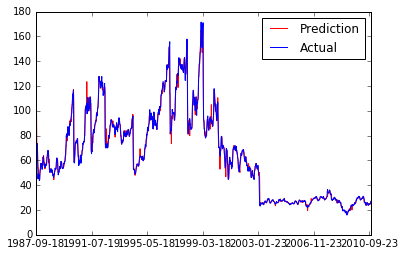

In [13]:
##without volume
prediction = randomForestRegression.predict(trainData)
prediction = pd.Series(prediction, trainData.index)
evaluateModel(prediction,trainOutput)

('Pearson Correlation Coeefiecient: ', (0.99838360560974659, 0.0))
('Normalised RMSE', 0.95308021591286429)


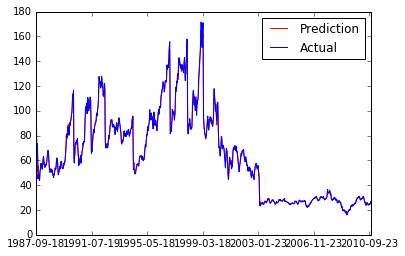

In [8]:
##with volume
prediction = randomForestRegression.predict(trainData)
prediction = pd.Series(prediction, trainData.index)
evaluateModel(prediction,trainOutput)

('Pearson Correlation Coeefiecient: ', (0.78594387599072857, 1.33678045360951e-64))
('Normalised RMSE', 2.8918030689260479)


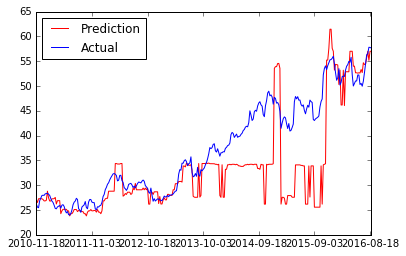

In [21]:
##without volume
prediction = randomForestRegression.predict(testData)
prediction = pd.Series(prediction, testData.index)
evaluateModel(prediction,testOutput)

('Pearson Correlation Coeefiecient: ', (0.85042442344774649, 1.1288566554131417e-85))
('Normalised RMSE', 2.5202534143706545)


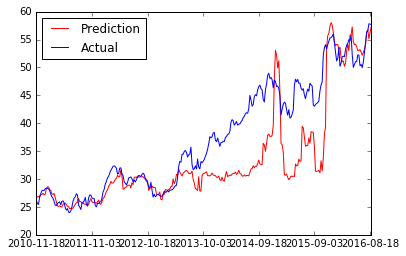

In [9]:
##with volume
prediction = randomForestRegression.predict(testData)
prediction = pd.Series(prediction, testData.index)
evaluateModel(prediction,testOutput)

that worked a lot better, now lets try classification

EDIT: previously i started without adding volume's feature in the model, but after doing some reading, i added volume traded as a feature in the model building, and it turns out to improve the model

## Increase Decrease Classification

In [10]:
Clf = []
previousday=msftweek.Open[0]
for stock in msftweek.Open[1:]:    
    if (stock > previousday):
        Clf.append(1)
    else:
        Clf.append(-1)
    previousday = stock

In [11]:
Clf = pd.Series(Clf , index=msftweek.index[1:])
Clf=Clf[newfeatures.index]

In [12]:
trainClf = Clf[:(int)(len(newfeatures)*0.8)]
testClf = Clf[(-(int)(len(newfeatures)*0.2)):]

In [13]:
params2 =[ {'criterion':[ 'gini', 'entropy'],
          'max_features':['auto', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[False],
          'oob_score':[False],
          'min_samples_leaf':[1,2,3],},
         {'criterion':[ 'gini', 'entropy'],
          'max_features':['auto', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[True],
          'oob_score':[True],
          'min_samples_leaf':[1,2,3],}
        ]

In [38]:
##without volume
randomForestClassifier = RFC()
gridsearch = GS(randomForestClassifier, param_grid=params2)
gridsearch.fit(trainData,trainClf)
gridsearch.best_params_

/Users/chuanfuyap/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'oob_score': False}

In [14]:
##with volume
randomForestClassifier = RFC()
gridsearch = GS(randomForestClassifier, param_grid=params2)
gridsearch.fit(trainData,trainClf)
gridsearch.best_params_

/Users/chuanfuyap/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'oob_score': False}

In [72]:
##without volume
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'entropy',
 max_features= 'auto',
 min_samples_leaf= 3,
 min_samples_split= 3,
 oob_score= False
    )

In [73]:
randomForestClassifier.fit(trainData,trainClf)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [74]:
##without volume 
prediction = randomForestClassifier.predict(trainData)

from __future__ import division

trackright=0
for x , y in zip(prediction, trainClf):
    if (x==y):
        trackright+=1
trackright/len(trainClf)

1.0

In [75]:
##without volume 

prediction = randomForestClassifier.predict(testData)

from __future__ import division

trackright=0
for x , y in zip(prediction, testClf):
    if (x==y):
        trackright+=1
trackright/len(testClf)

0.5993377483443708

In [83]:
##with volume
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'entropy',
 max_features= 'log2',
 min_samples_leaf= 3,
 min_samples_split= 2,
 oob_score= False
    )

In [84]:
randomForestClassifier.fit(trainData,trainClf)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
##with volume 
prediction = randomForestClassifier.predict(trainData)

from __future__ import division

trackright=0
for x , y in zip(prediction, trainClf):
    if (x==y):
        trackright+=1
trackright/len(trainClf)

1.0

In [86]:
##with volume 

prediction = randomForestClassifier.predict(testData)

from __future__ import division

trackright=0
for x , y in zip(prediction, testClf):
    if (x==y):
        trackright+=1
trackright/len(testClf)

0.5761589403973509

using stats features without volume as a feature increased increase/decrease prediction by 8%, but using volume as a feature increased the prediction by 5% from using just sentiments alone which was giving a 52% results

overall, using stats features for prediction, improves the model prediction.

## now let's try a new classification method

3 - BUY

2 - HOLD

1 - SELL

I will be simplifying the problem whereby when stock price of the day CLOSE with HIGHER value than OPEN, client should BUY, and if stock value keeps climbing up, client would HOLD, the moment CLOSE value is lower than OPEN, client should sell on that day.

CLOSE > OPEN = BUY (3)
nextday>previousday = HOLD (2)
CLOSE < OPEN = SELL (1)

The idea is that client would have minimal loss/risk involved in trading, buying when stock is predicted by the model to go up, and selling as soon as model predicts a drop, however this now looks the trade on the day itself. While, also including day to day trade to determine if client should hold to allow the stock to appreciate in value further.

In [42]:
Clf2 = []
previousday=msftweek.Open[0]
previousclose = msftweek.Close[0]
for op, cl in zip(msftweek.Open[1:], msftweek.Close[1:]):   
    if ((op > previousday) & (previousday<previousclose)):
        Clf2.append(2)
    elif (op>cl):
        Clf2.append(1)
    elif(op<cl):
        Clf2.append(3)
    elif(op==cl):
        Clf2.append(2)
    previousday = op
    previousclose = cl

In [43]:
Clf2 = pd.Series(Clf2 , index=msftweek.index[1:])
Clf2=Clf2[newfeatures.index]

In [44]:
trainClf2 = Clf2[:(int)(len(newfeatures)*0.8)]
testClf2 = Clf2[(-(int)(len(newfeatures)*0.2)):]

In [47]:
##with volume
randomForestClassifier = RFC()
gridsearch = GS(randomForestClassifier, param_grid=params2)
gridsearch.fit(trainData,trainClf2)
gridsearch.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'oob_score': False}

In [87]:
##with volume
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'entropy',
 max_features= 'log2',
 min_samples_leaf= 3,
 min_samples_split= 2,
 oob_score= False
    )

In [88]:
randomForestClassifier.fit(trainData, trainClf2)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [89]:
##with volume 
prediction = randomForestClassifier.predict(trainData)

from __future__ import division

trackright=0
for x , y in zip(prediction, trainClf2):
    if (x==y):
        trackright+=1
trackright/len(trainClf2)

1.0

In [90]:
##with volume 

prediction = randomForestClassifier.predict(testData)

from __future__ import division

trackright=0
for x , y in zip(prediction, testClf2):
    if (x==y):
        trackright+=1
trackright/len(testClf2)

0.40397350993377484

In [59]:
##without volume
col = ['Volume_gradient', 'Volume_mean','Volume_median','Volume_std']
newfeatures2 = newfeatures.drop(col, axis=1)
newfeatures2.head()

,Open_gradient,Open_mean,Open_median,Open_std,Bullish_gradient,Bullish_mean,Bullish_median,Bullish_std,Neutral_gradient,Neutral_mean,Neutral_median,Neutral_std,Bearish_gradient,Bearish_mean,Bearish_median,Bearish_std
1987-09-18,1.304630,104.637037,102.208333,6.877166,0.015929,0.457158,0.450000,0.111823,0.004550,0.294745,0.280000,0.121980,-0.020479,0.248097,0.270000,0.096415
1987-09-25,1.982870,106.501852,103.333333,7.636658,0.026667,0.481111,0.500000,0.116661,-0.021111,0.292222,0.280000,0.121818,-0.005556,0.226667,0.260000,0.103064
1987-10-02,-6.444444,102.825926,103.333333,14.604782,0.042778,0.500000,0.520000,0.109036,-0.059444,0.255556,0.230000,0.101774,0.016667,0.244444,0.270000,0.100345
1987-10-09,-3.254630,99.034259,103.333333,18.969834,-0.024444,0.520000,0.520000,0.074087,0.028333,0.231111,0.230000,0.064540,-0.003889,0.248889,0.290000,0.101811
1987-10-16,-2.629630,96.557407,103.333333,20.615426,0.013889,0.508889,0.500000,0.074751,0.007778,0.257778,0.260000,0.074353,-0.021667,0.233333,0.270000,0.104987
1987-10-23,-3.127315,93.177778,103.333333,21.867211,-0.045000,0.500000,0.500000,0.085245,-0.008333,0.252222,0.260000,0.068925,0.053333,0.247778,0.300000,0.108298
1987-10-30,-6.750000,87.974074,73.500000,24.271592,-0.018889,0.470000,0.460000,0.069761,0.012778,0.254444,0.260000,0.070097,0.006111,0.275556,0.300000,0.086424
1987-11-06,-8.702778,80.562037,71.791667,25.979320,0.009444,0.461111,0.440000,0.067896,0.006111,0.260000,0.260000,0.065828,-0.015556,0.278889,0.300000,0.087869
1987-11-13,-6.722685,73.094444,67.041667,24.236666,0.003889,0.466667,0.460000,0.066332,0.016667,0.275556,0.290000,0.058899,-0.020556,0.257778,0.300000,0.075833
1987-11-20,-10.384259,65.902778,64.541667,20.546714,-0.045000,0.445556,0.440000,0.080982,0.012222,0.295556,0.300000,0.069620,0.032778,0.258889,0.300000,0.076077


In [60]:
trainData2 = newfeatures2[:(int)(len(newfeatures2)*0.8)]
testData2 = newfeatures2[(-(int)(len(newfeatures2)*0.2)):]

In [61]:
##without volume
randomForestClassifier = RFC()
gridsearch = GS(randomForestClassifier, param_grid=params2)
gridsearch.fit(trainData2,trainClf2)
gridsearch.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'oob_score': True}

In [76]:
##without volume
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= True,
 criterion= 'gini',
 max_features= 'log2',
 min_samples_leaf= 1,
 min_samples_split= 3,
 oob_score= True
    )

In [77]:
randomForestClassifier.fit(trainData2, trainClf2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [78]:
##without volume 
prediction = randomForestClassifier.predict(trainData2)

from __future__ import division

trackright=0
for x , y in zip(prediction, trainClf2):
    if (x==y):
        trackright+=1
trackright/len(trainClf2)

1.0

In [79]:
##without volume 

prediction = randomForestClassifier.predict(testData2)

from __future__ import division

trackright=0
for x , y in zip(prediction, testClf2):
    if (x==y):
        trackright+=1
trackright/len(testClf2)

0.41721854304635764

This new classification method doesn't seem to help much in improving the model, and it seems volumes traded in the  day does not improve model's prediction when it comes classification problem.

## Regression seems to be working well, fortunately